In [1]:
import random
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from shapely.geometry import Polygon,LineString
from shapely import affinity
from descartes.patch import PolygonPatch
from matplotlib import pyplot
from figures import BLUE, SIZE, set_limits, plot_coords, color_isvalid,RED
from IPython.display import clear_output

In [2]:
def convertbinary(x):
    binary= '{0:b}'.format(int(x))
    return binary

In [3]:
#x= 1-400 y = 1-300
def binarytoint(chrome,numBaju):
    hasil = []
    for baju in range(numBaju):
        index=baju*22
        x=(int("".join(str(x) for x in chrome[index:index+9]), 2) )
        y=(int("".join(str(x) for x in chrome[index+9:index+18]), 2) )
        sudut=(int("".join(str(x) for x in chrome[index+18:index+22]), 2) )
        #x
        x = int(1+((399*x)/((2**9)-1)))
        #y
        y = int(1+((299*y)/((2**9)-1)))
        #sudut
        sudut = int((15*sudut)/((2**4)-1))
        hasil.append([x,y,sudut])
    return hasil

In [4]:
def createpopulation(chromosome,gene):
    pop=[]
    for j in range(chromosome):
        pop.append(np.random.randint(0,2,gene).tolist())
    return pop

In [5]:
#9 slot untuk x, 9 untuk y , untuk sudut istimewa 4
numBaju = 10
numChromosome = 10
bit = createpopulation(numChromosome,numBaju*22)
real=[]
for perchrom in bit :
    hasil = binarytoint(perchrom,numBaju)
    #diganti jadi bilangan real untuk mempermudah checking, global variable mending bit aja baru diconvert kalau perlu
    real.append(hasil)
# print(real)

In [6]:
def poligonbuild(shape,n):
    g = []
    for i in range(0,n):
        f = Polygon(shape)
        g.append(f)
    return g

In [7]:
def list_center(g): 
    cen_list = np.array([[0,0]])
    for i in range (0,len(g)):
        cen_list = np.concatenate((cen_list,[g[i].centroid.bounds[0:2]]))
    cen_list = np.delete(cen_list,0,axis=0)
    return cen_list

In [8]:
def plot_all(g):
    %config InlineBackend.figure_format = 'svg'
    fig = pyplot.figure(1, figsize=(15,5))
    ax = fig.add_subplot(121)
    ax.grid()
    axes = fig.gca()
    axes.set_xlim([0,400])
    axes.set_ylim([0,300])
    for i in range(0,len(g)):
        polygon= g[i]
        patch = PolygonPatch(polygon, facecolor=color_isvalid(polygon,valid=BLUE), alpha=0.5, zorder=2)
        ax.add_patch(patch)

In [9]:
def update_center(g,new_center,new_teta):
    g_new = g
    for i in range(0,len(g_new)):
        off_pos = new_center[i] - g_new[i].centroid.bounds[0:2][0]
        g_new[i] = affinity.translate(g_new[i],xoff=off_pos[0],yoff=off_pos[1])
        g_new[i] = affinity.rotate(g_new[i],angle=new_teta[i],origin='centroid')
    return g_new

In [10]:
# def detect_intersection(f):
#     result = False
#     for i in range  (0,len(f)):
#         if result:
#             break
#         for ii in range (i+1,len(f)):
#             result =  (f[i].intersects(f[ii]))
#             if result:
#                 break
#     return result
def detect_intersection(f,yMax=300,xMax=400):
    xMin = 0
    yMin = 0
    result = False
    for i in f:
        minPolyX = i.bounds[0]
        minPolyY = i.bounds[1]
        maxPolyX = i.bounds[2]
        maxPolyY = i.bounds[3]
        if minPolyY < yMin:
            #print('out of boundary')
            result = True
            return result
        if minPolyX < xMin:
            #print('out of boundary')
            result = True
            return result
        if maxPolyY > yMax:
            #print('out of boundary')
            result = True
            return result
        if maxPolyX > xMax:
            #print('out of boundary')
            result = True
            return result

    for i in range  (0,len(f)):
        if result:
            break
        for ii in range (i+1,len(f)):
            result =  (f[i].intersects(f[ii]))
            if result:
                #print('Intersect')
                break
    return result

In [11]:
def obj_func(list_center):
    x = np.max(list_center[:,0])
    y = np.max(list_center[:,1])
    return x*y

In [12]:
# Build the  real shape
sh1 = [[0,0],[0,20],[30,10]]
sh2 = [[0,0],[0,20],[20,20],[20,0]]
sh3 = [[0,0],[0,20],[20,40],[40,0]]
sh4 = [[0,0],[0,20],[40,20],[40,0]]

In [13]:
#Example poligon have this constraint
g1 = poligonbuild(sh1,3)
g2 = poligonbuild(sh2,2)
g3 = poligonbuild(sh3,4)
g4 = poligonbuild(sh4,1)
ori_pos = g1+g2+g3+g4
ori_center  = list_center(ori_pos)

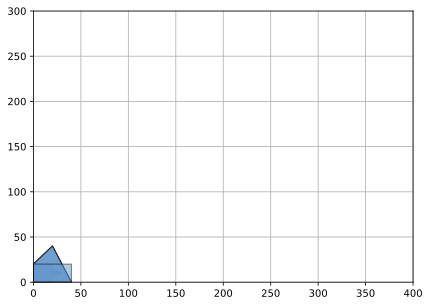

In [14]:
plot_all(ori_pos)

In [15]:
def changetodegree(rotation):
    degree=0
    if(rotation==1):
        degree=30
    elif(rotation==2):
        degree=45
    elif(rotation==3):
        degree=60
    elif(rotation==4):
        degree=90
    elif(rotation==5):
        degree=120
    elif(rotation==6):
        degree=135
    elif(rotation==7):
        degree=150
    elif(rotation==8):
        degree=180
    elif(rotation==9):
        degree=210
    elif(rotation==10):
        degree=235
    elif(rotation==11):
        degree=240
    elif(rotation==12):
        degree=270
    elif(rotation==13):
        degree=300
    elif(rotation==14):
        degree=315
    elif(rotation==15):
        degree=330
    else:
        degree=0
    return degree

In [16]:
def evalintersect(bit,ori_center,numBaju):
    real=[]
    for perchrom in bit :
        hasil = binarytoint(perchrom,numBaju)
        real.append(hasil)
    new_center=ori_center.copy()
    new_rotate=[]
    delChrom_index=[]
    chromosome_index=0
    for chromosome in real:
        shape_index=0
        for shape in chromosome:
            new_center[shape_index] = [shape[0],shape[1]]
            degree=changetodegree(shape[2])
            new_rotate.append(degree)
            shape_index=shape_index+1
        #print(new_center,new_rotate)
        new_pos = update_center(ori_pos.copy(),new_center,new_rotate)
#         if(chromosome_index==6):
#             plot_all(new_pos)
#             print(detect_intersection(new_pos))
            #break
        new_rotate.clear()
        #detect intersection
        if(detect_intersection(new_pos)==True):
            delChrom_index.append(chromosome_index)
        chromosome_index=chromosome_index+1
    new_bit = bit.copy()
    if delChrom_index :
        #print(delChrom_index)
        for x in delChrom_index[::-1]:
            new_bit.pop(x)
    return new_bit

In [17]:
def repopulation(bit):
    global numChromosome,numBaju
    temp=createpopulation(numChromosome-len(bit),numBaju*22)
    total=bit+temp
    return total

In [18]:
def roulettewheel(bit):
    global ori_center,numBaju
    real=[]
    new_rotate=[]
    distance_collection=[]
    normalize_collection =[]
    for perchrom in bit :
        hasil = binarytoint(perchrom,numBaju)
        real.append(hasil)
    new_center=ori_center.copy()
    chromosome_index=0
    for chromosome in real:
        shape_index=0
        for shape in chromosome:
            new_center[shape_index] = [shape[0],shape[1]]
            degree=changetodegree(shape[2])
            new_rotate.append(degree)
            shape_index=shape_index+1
        new_pos = update_center(ori_pos.copy(),new_center,new_rotate)
        distance = obj_func(list_center(new_pos))
        #distance_collection = titik terjauh berdasarkan urutan bit
        #1/distance karena minimalisasi
        distance_collection.append(1/distance)
    for distance in distance_collection:
        normalize_collection.append(distance/sum(distance_collection))
    randomizer = np.random.uniform(0.0,1.0)
    cumulative = 0
    index = 0
    #print(normalize_collection)
    for i in range(len(normalize_collection)):
        cumulative = cumulative + normalize_collection[i]
        if (cumulative>randomizer):
            index = i
            break
    parent1 = bit[index]
    temp_collection = normalize_collection.copy()
    temp_collection.pop(index)
    randomizer = np.random.uniform(0.0,1.0)
    cumulative = 0
    for j in range(len(temp_collection)):
        cumulative = cumulative + temp_collection[j]
        if (cumulative>randomizer):
            index = j
            break
    parent2 = bit[index]
    return parent1,parent2

In [19]:
def xmutate(parent1,parent2,cr,mr):
    global numBaju
    child1 = parent1.copy()
    child2 = parent2.copy()
    randomizer = np.random.uniform(0.0,1.0)
    #print("cr",randomizer)
    if(randomizer<cr):
        n_crossover = random.randint(1,numBaju)
        for i in range(n_crossover):
            index1 = random.randint(0,(22*numBaju)-1)
            index2 = random.randint(0,(22*numBaju)-1)
            temp1=parent2[index2]
            temp2=parent1[index1]
            child1[index1]=temp1
            child2[index2]=temp2
    #child 1 MR
    randomizer = np.random.uniform(0.0,1.0)
    #print("mr",randomizer)
    if(randomizer<mr):
        n_mutation = random.randint(1,numBaju)
        for j in range(n_mutation):
            index = random.randint(0,(22*numBaju)-1)
            for x in child1[index*22:index*22+22]:
                if(x==0):
                    child1[index*22+x]=1
                elif(x==1):
                    child1[index*22+x]=0
    #child 2 MR
    randomizer = np.random.uniform(0.0,1.0)
    #print("mr",randomizer)
    if(randomizer<mr):
        n_mutation = random.randint(1,numBaju)
        for j in range(n_mutation):
            index = random.randint(0,(22*numBaju)-1)
            for x in child2[index*22:index*22+22]:
                if(x==0):
                    child2[index*22+x]=1
                elif(x==1):
                    child2[index*22+x]=0
    return child1,child2

In [20]:
def getbestdistance(bit):
    global ori_center,numBaju
    real=[]
    new_rotate=[]
    distance_collection = []
    for perchrom in bit :
        hasil = binarytoint(perchrom,numBaju)
        real.append(hasil)
    new_center=ori_center.copy()
    chromosome_index=0
    for chromosome in real:
        shape_index=0
        for shape in chromosome:
            new_center[shape_index] = [shape[0],shape[1]]
            degree=changetodegree(shape[2])
            new_rotate.append(degree)
            shape_index=shape_index+1
        new_pos = update_center(ori_pos.copy(),new_center,new_rotate)
#         if(chromosome_index==8):
#             plot_all(new_pos)
            #print(detect_intersection(new_pos))
            #break
        new_rotate.clear()
        chromosome_index=chromosome_index+1
        distance = obj_func(list_center(new_pos))
        distance_collection.append(distance)
    min_distance = min(distance_collection)
    min_index = distance_collection.index(min(distance_collection))
    min_bit = bit[min_index]
    return min_distance,min_bit

In [21]:
def drawmapping(bit,ori_center,numBaju):
    global ori_pos
    new_rotate=[]
    real = binarytoint(bit,numBaju)
    new_center=ori_center.copy()
    chromosome_index=0
    shape_index=0
    for shape in real:
        new_center[shape_index] = [shape[0],shape[1]]
        degree=changetodegree(shape[2])
        new_rotate.append(degree)
        shape_index=shape_index+1
    new_pos = update_center(ori_pos.copy(),new_center,new_rotate)
    plot_all(new_pos)

In [22]:
def checker(bit):
    global ori_center,numBaju
    real=[]
    new_rotate=[]
    distance_collection = []
    for perchrom in bit :
        hasil = binarytoint(perchrom,numBaju)
        real.append(hasil)
    new_center=ori_center.copy()
    chromosome_index=0
    for chromosome in real:
        shape_index=0
        for shape in chromosome:
            new_center[shape_index] = [shape[0],shape[1]]
            degree=changetodegree(shape[2])
            new_rotate.append(degree)
            shape_index=shape_index+1
        new_pos = update_center(ori_pos.copy(),new_center,new_rotate)
        if(chromosome_index==6):
            plot_all(new_pos)
        chromosome_index=chromosome_index+1
        new_rotate.clear()

In [23]:
crossover_rate = 0.9
mutation_rate = 0.1
num_generation = 10000
min_distance_collection = []
new_gen=[]
eval_bit = evalintersect(bit,ori_center,numBaju)
#evaluasi ada yg bersinggungan
while (len(eval_bit)!=numChromosome):
    new_bit=repopulation(eval_bit)
    eval_bit=evalintersect(new_bit,ori_center,numBaju)
    #print(len(eval_bit))
min_distance,min_bit=getbestdistance(eval_bit)
min_distance_collection.append([min_distance,min_bit])
#membuat anak sampai penuh
for i in range(num_generation-1):
    clear_output()
    print(i)
    print(min_distance)
    while(len(new_gen)< numChromosome):
        temp=[]
        for j in range(int(numChromosome/2.0)):
            parent1,parent2=roulettewheel(eval_bit)
            #print("Parent 1 :",binarytoint(parent1,numBaju),"parent 2 ",binarytoint(parent2,numBaju))
            child1,child2=xmutate(parent1,parent2,crossover_rate,mutation_rate)
            #print("child 1:",binarytoint(child1,numBaju),"child 2 :",binarytoint(child2,numBaju))
            temp.append(child1)
            temp.append(child2)
        new_gen=new_gen + evalintersect(temp,ori_center,numBaju)
        #print(len(new_gen))
    if(len(new_gen)>numChromosome):
        new_gen=new_gen[0:numChromosome]
    min_distance,min_bit=getbestdistance(new_gen)
    min_distance_collection.append([min_distance,min_bit])
    eval_bit=new_gen.copy()
    new_gen.clear()

9998
69333.00000000003


In [26]:
from tqdm import tqdm_notebook as tqdm

In [28]:
pbar = tqdm(total=100)
for i in range(num_generation):
    if i%100==0:
        pbar.update(1)
    while(len(new_gen)< numChromosome):
        temp=[]
        for j in range(int(numChromosome/2.0)):
            parent1,parent2=roulettewheel(eval_bit)
            #print("Parent 1 :",binarytoint(parent1,numBaju),"parent 2 ",binarytoint(parent2,numBaju))
            child1,child2=xmutate(parent1,parent2,crossover_rate,mutation_rate)
            #print("child 1:",binarytoint(child1,numBaju),"child 2 :",binarytoint(child2,numBaju))
            temp.append(child1)
            temp.append(child2)
        new_gen=new_gen + evalintersect(temp,ori_center,numBaju)
        #print(len(new_gen))
    if(len(new_gen)>numChromosome):
        new_gen=new_gen[0:numChromosome]
    min_distance,min_bit=getbestdistance(new_gen)
    min_distance_collection.append([min_distance,min_bit])
    eval_bit=new_gen.copy()
    new_gen.clear()

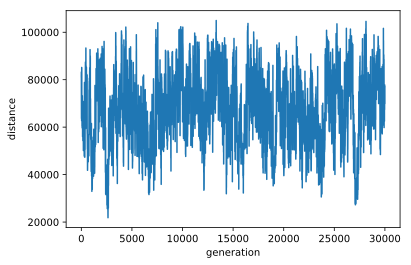

In [30]:
x= [x[0] for x in min_distance_collection]
y= [i for i in range(3*num_generation)]
plt.plot(y,x)
plt.ylabel("distance")
plt.xlabel("generation")
#plt.xlim(max(y),min(y)) 
plt.show()

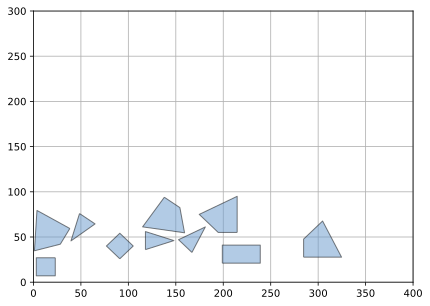

In [25]:
index_min = x.index(min(x))
drawmapping(min_distance_collection[index_min][1],ori_center,numBaju)

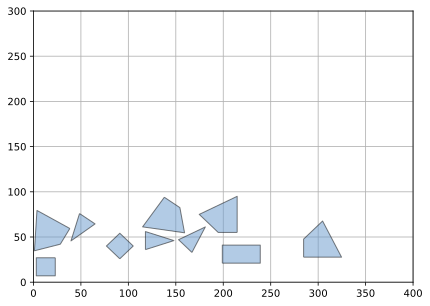

In [31]:
index_min = x.index(min(x))
drawmapping(min_distance_collection[index_min][1],ori_center,numBaju)